<a href="https://colab.research.google.com/github/wingyen/GiT_savvy_sisters/blob/liza/More_features_41_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install shap
import numpy as np
import pandas as pd
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
import shap
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
df = pd.read_csv(r"drive/MyDrive/data_set.csv")

print("Number of df samples are",df.shape)

categorical_features = ['State_Factor', 'building_class', 'facility_type']
numerical_features=df.select_dtypes('number').columns


Number of df samples are (75757, 64)


Text(0.5, 1.0, 'Missing values in  Data')

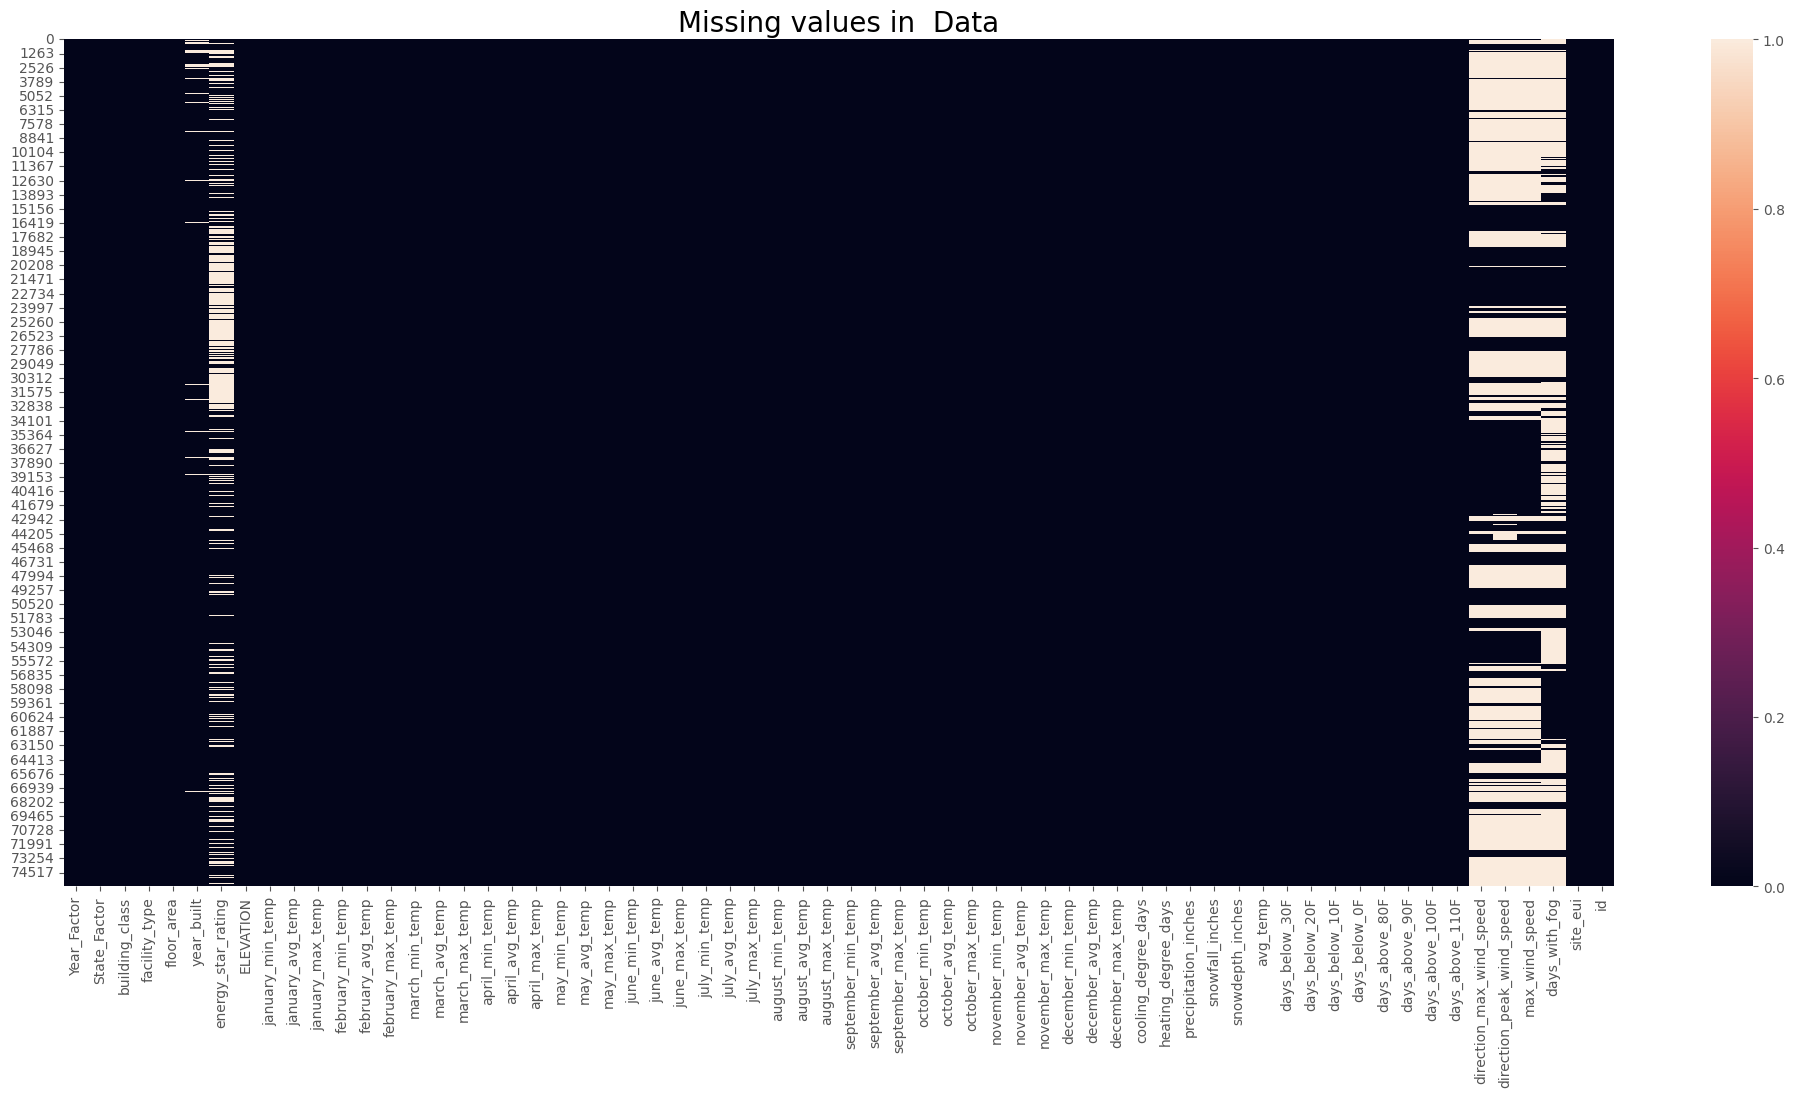

In [4]:
plt.figure(figsize = (25,11))
sns.heatmap(df.isna().values, xticklabels=df.columns)
plt.title("Missing values in  Data", size=20)

In [137]:
missing_columns = [col for col in df.columns if df[col].isnull().any()]
missingvalues_count =df.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df.style.background_gradient(cmap="Pastel1")

df['year_built'] =df['year_built'].replace(np.nan, 2022)
null_col=['energy_star_rating','direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog']
imputer = SimpleImputer()
imputer.fit(df[null_col])
data_transformed = imputer.transform(df[null_col])
df[null_col] = pd.DataFrame(data_transformed)

Text(0.5, 1.0, 'Missing values in training Data')

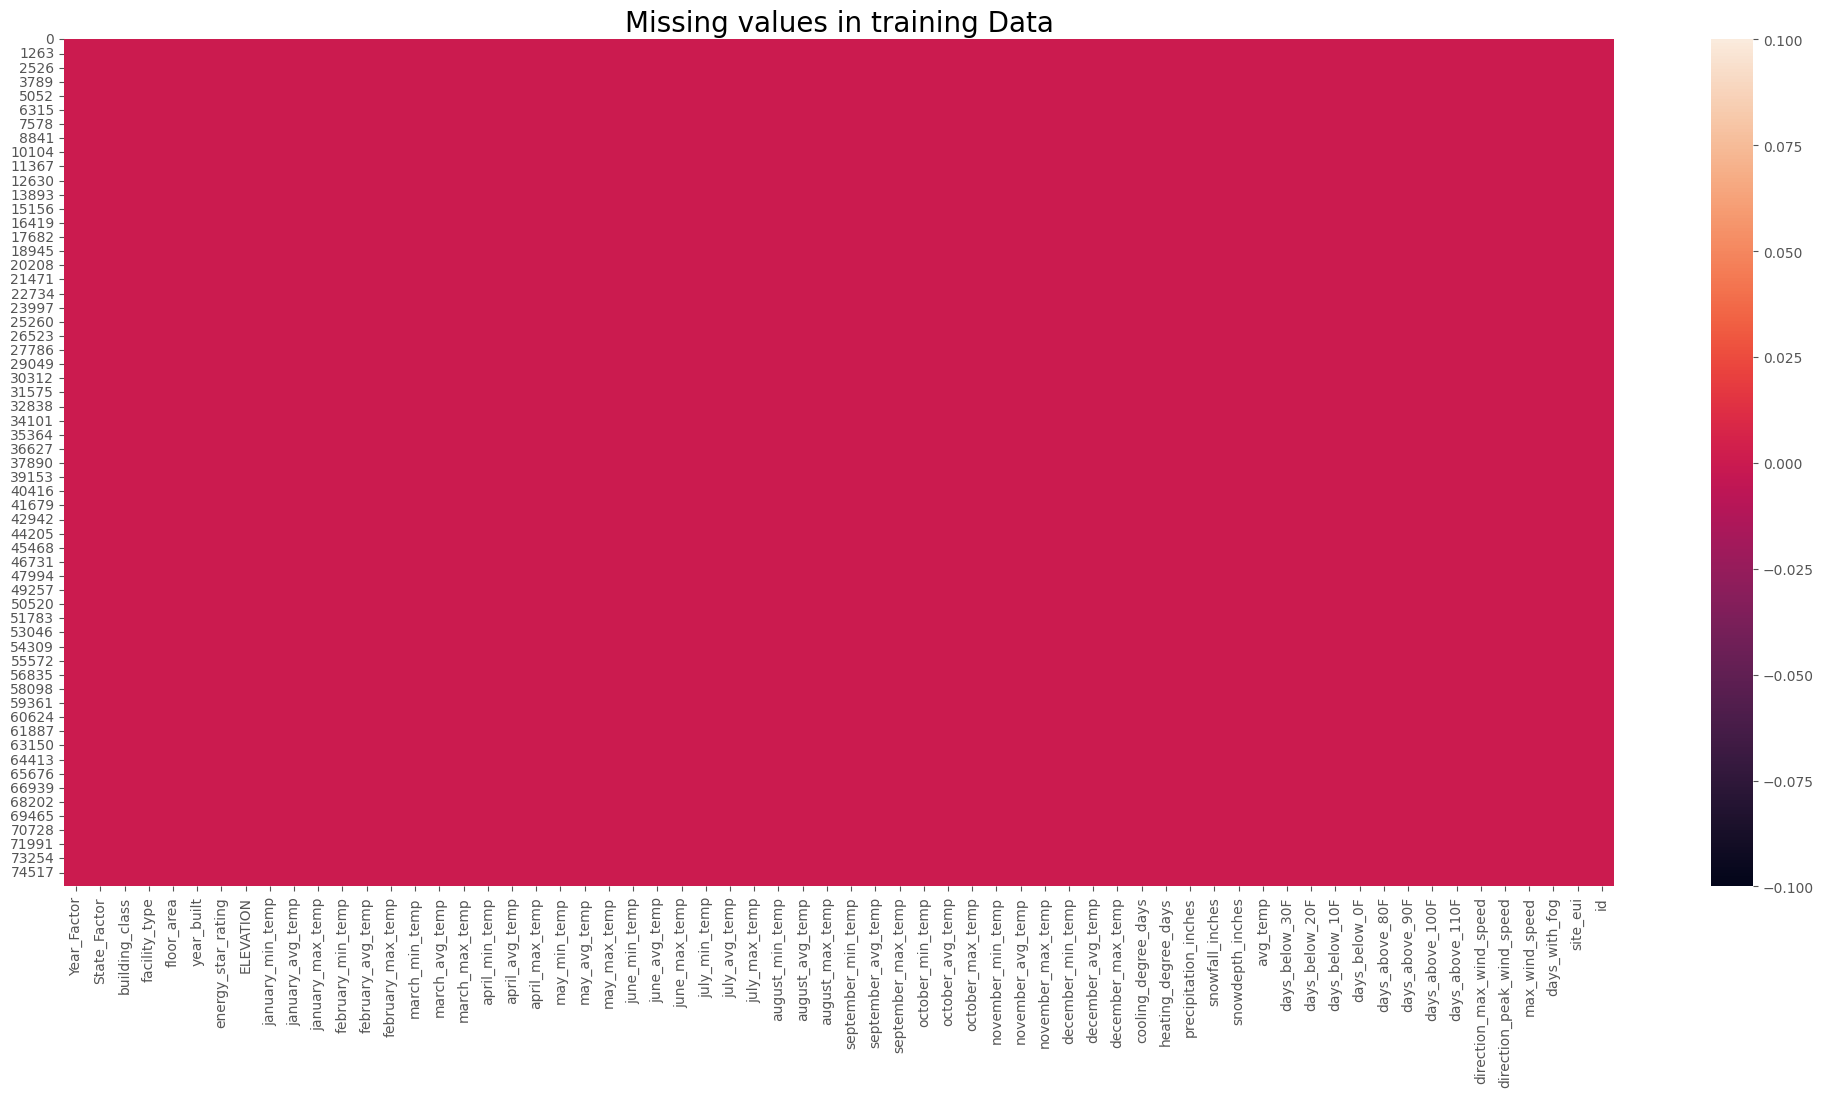

In [6]:
plt.figure(figsize = (25,11))
sns.heatmap(df.isna().values, xticklabels=df.columns)
plt.title("Missing values in training Data", size=20)

# Feature Engineering

In [138]:
le = LabelEncoder()
for col in categorical_features:
    df[f'{col}_label'] = le.fit_transform(df[col])


In [139]:
# add mean facility value
mean_values = df.groupby('facility_type')['site_eui'].transform('mean')
df['mean_value_by_facility_type'] = mean_values
print(df['mean_value_by_facility_type'])

0        241.135162
1         39.559542
2        100.965937
3         69.441531
4         38.209399
            ...    
75752     77.074389
75753     36.737785
75754     92.642037
75755     92.642037
75756     31.876915
Name: mean_value_by_facility_type, Length: 75757, dtype: float64


## OneHotEncoded features

In [140]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(df[['building_class']])

one_hot_encoded = enc.transform(df[['building_class']])
encoded_df = pd.DataFrame(one_hot_encoded, columns=['is_commercial', 'is_residential'])
df['is_commercial'] = encoded_df['is_commercial']
df['is_residential'] = encoded_df['is_residential']

In [141]:
def extract_main_facility_type(facility_type):
  return facility_type.split('_') [0]

def extract_secondary_facility_type(facility_type):
  return '_'.join(facility_type.split('_')[1:])

In [142]:
# Split facility type in 2 parts: Main category and subcategory and transform it to one-hot
df['facility_type_2'] = df['facility_type'].apply(lambda x: extract_secondary_facility_type(x))
df['facility_type_1'] = df['facility_type'].apply(lambda x: extract_main_facility_type(x))
mean_values = df.groupby('facility_type_2')['site_eui'].transform('mean')
# Add the mean values as a new column
df['mean_value_by_facility_type_2'] = mean_values

mean_values = df.groupby('facility_type_1')['site_eui'].transform('mean')
# Add the mean values as a new column
df['mean_value_by_facility_type_1'] = mean_values


In [143]:
facility_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
facility_enc.fit(df[['facility_type_1']])
one_hot_facility_type = facility_enc.transform(df[['facility_type_1']])
for i, category in enumerate(facility_enc.categories_[0]):
  df[f'is_{category}'] = one_hot_facility_type[:, i]
facility_enc.fit(df[['facility_type_2']])
one_hot_facility_type = facility_enc.transform(df[['facility_type_2']])
for i, category in enumerate(facility_enc.categories_[0]):
  df[f'is_{category}'] = one_hot_facility_type[:, i]


In [109]:
df.describe().style.background_gradient()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,State_Factor_label,building_class_label,facility_type_label,mean_value_by_facility_type,is_commercial,is_residential,is_2to4_Unit_Building,is_5plus_Unit_Building,is_Commercial_Other,is_Commercial_Unknown,is_Data_Center,is_Education_College_or_university,is_Education_Other_classroom,is_Education_Preschool_or_daycare,is_Education_Uncategorized,is_Food_Sales,is_Food_Service_Other,is_Food_Service_Restaurant_or_cafeteria,is_Food_Service_Uncategorized,is_Grocery_store_or_food_market,is_Health_Care_Inpatient,is_Health_Care_Outpatient_Clinic,is_Health_Care_Outpatient_Uncategorized,is_Health_Care_Uncategorized,is_Industrial,is_Laboratory,is_Lodging_Dormitory_or_fraternity_sorority,is_Lodging_Hotel,is_Lodging_Other,is_Lodging_Uncategorized,is_Mixed_Use_Commercial_and_Residential,is_Mixed_Use_Predominantly_Commercial,is_Mixed_Use_Predominantly_Residential,is_Multifamily_Uncategorized,is_Nursing_Home,is_Office_Bank_or_other_financial,is_Office_Medical_non_diagnostic,is_Office_Mixed_use,is_Office_Uncategorized,is_Parking_Garage,is_Public_Assembly_Drama_theater,is_Public_Assembly_Entertainment_culture,is_Public_Assembly_Library,is_Public_Assembly_Movie_Theater,is_Public_Assembly_Other,is_Public_Assembly_Recreation,is_Public_Assembly_Social_meeting,is_Public_Assembly_Stadium,is_Public_Assembly_Uncategorized,is_Public_Safety_Courthouse,is_Public_Safety_Fire_or_police_station,is_Public_Safety_Penitentiary,is_Public_Safety_Uncategorized,is_Religious_worship,is_Retail_Enclosed_mall,is_Retail_Strip_shopping_mall,is_Retail_Uncategorized,is_Retail_Vehicle_dealership_showroom,is_Service_Drycleaning_or_Laundry,is_Service_Uncategorized,is_Service_Vehicle_service_repair_shop,is_Warehouse_Distribution_or_Shipping_center,is_Warehouse_Nonrefrigerated,is_Warehouse_Refrigerated,is_Warehouse_Selfstorage,is_Warehouse_Uncategorized,facility_type_1,facility_type_2
count,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,

In [145]:
import copy
y = df["site_eui"]
train = df.drop(["site_eui","id"],axis =1)
trainnames = copy.deepcopy(train)
# scaler = StandardScaler()
# train = scaler.fit_transform(train)

In [152]:
train

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,is_Uncategorized,is_Unit_Building,is_Unknown,is_Use_Commercial_and_Residential,is_Use_Predominantly_Commercial,is_Use_Predominantly_Residential,is_Vehicle_dealership_showroom,is_Vehicle_service_repair_shop,is_store_or_food_market,is_worship
0,1,61242.0,1942.0,11.000000,2.4,36,50.500000,68,35,50.589286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,274000.0,1955.0,45.000000,1.8,36,50.500000,68,35,50.589286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,280025.0,1951.0,97.000000,1.8,36,50.500000,68,35,50.589286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,55325.0,1980.0,46.000000,1.8,36,50.500000,68,35,50.589286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,66000.0,1985.0,100.000000,2.4,36,50.500000,68,35,50.589286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,20410.0,1995.0,8.000000,36.6,28,43.451613,56,34,47.672414,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75753,6,40489.0,1910.0,98.000000,36.6,28,43.451613,56,34,47.672414,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75754,6,28072.0,1917.0,61.048605,36.6,26,36.612903,48,30,41.637931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75755,6,53575.0,2012.0,61.048605,36.6,26,36.612903,48,30,41.637931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state = 50)


In [147]:
X_test_ft=pd.DataFrame(X_test,columns=trainnames.columns)
X_test_ft.shape

(15152, 139)

In [148]:
import xgboost
xgboost_model = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.02, gamma=0, subsample=0.75,
                           colsample_bytree=0.4, max_depth=5)
xgboost_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
! pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=965b54e4a80ef2df79ff1bc7a4ec33a885e9c485d9736718bb99185c5eba3b73
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [150]:
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgboost_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = trainnames.columns.tolist(), top=63)

Weight,Feature
0.2815 ± 0.0140,energy_star_rating
0.1110 ± 0.0071,mean_value_by_facility_type
0.0229 ± 0.0061,floor_area
0.0168 ± 0.0023,mean_value_by_facility_type_2
0.0168 ± 0.0028,mean_value_by_facility_type_1
0.0142 ± 0.0009,year_built
0.0104 ± 0.0010,State_Factor_label
0.0052 ± 0.0013,is_Office
0.0048 ± 0.0009,facility_type_label
0.0033 ± 0.0009,building_class_label


In [169]:
from sklearn.metrics import mean_squared_error
y_pred = xgboost_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)

NotFittedError: ignored

## Grid Search

In [153]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4],
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.2, 0.5],
    'gamma': [0.01, 0.05]
}

# Create an XGBoost regressor
xgboost_model = xgboost.XGBRegressor()

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 250, 'subsample': 0.9}
Root Mean Squared Error (RMSE) on Test Set: 41.69562123958508


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Columns: 126 entries, Year_Factor to is_Warehouse_Uncategorized
dtypes: float64(86), int64(40)
memory usage: 72.8 MB


In [183]:
y_pred_train = best_model.predict(X_train)
mse = np.sqrt(mean_squared_error(y_train, y_pred_train))

In [168]:
best_model.save_model('best_model.json')

# Explainer

In [158]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

[13:56:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


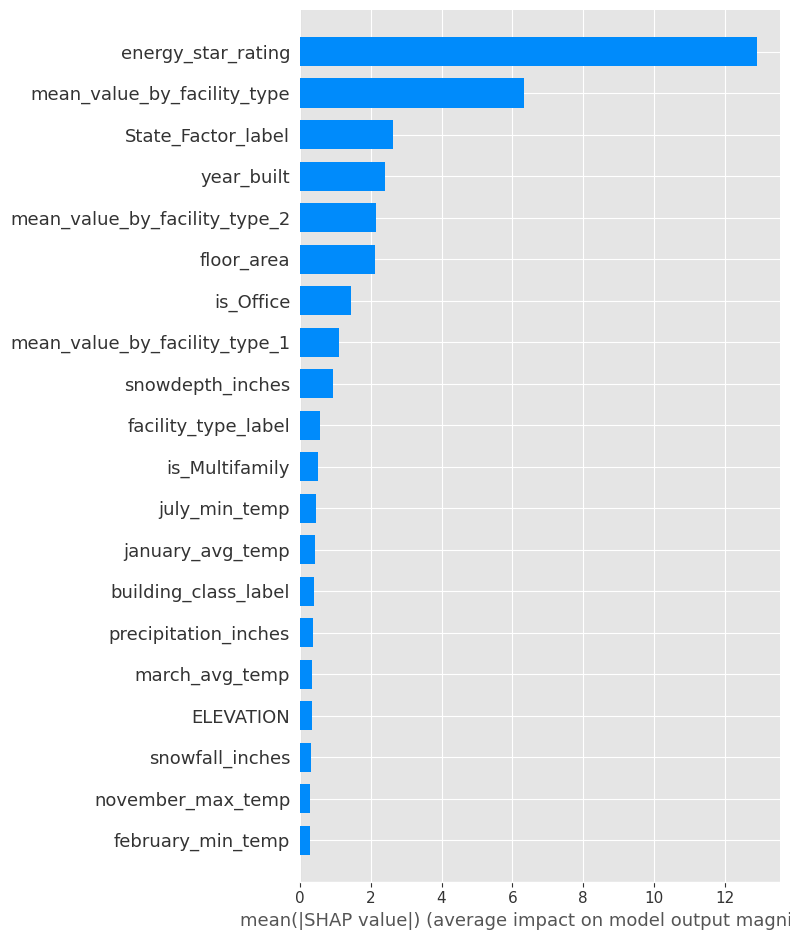

In [159]:
#Variable Importance Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

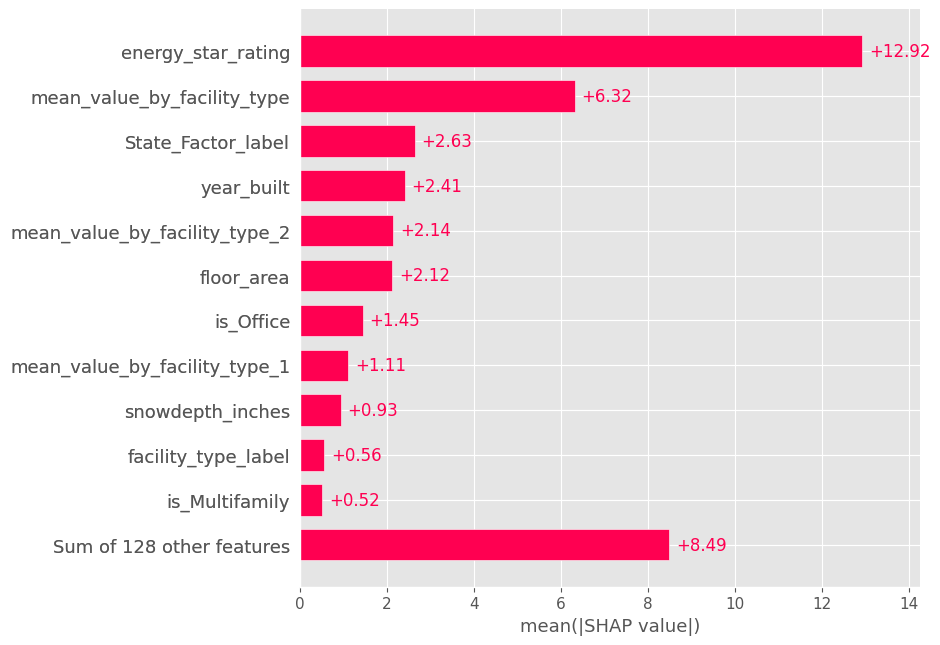

In [160]:
shap.plots.bar(shap_values,max_display=12)

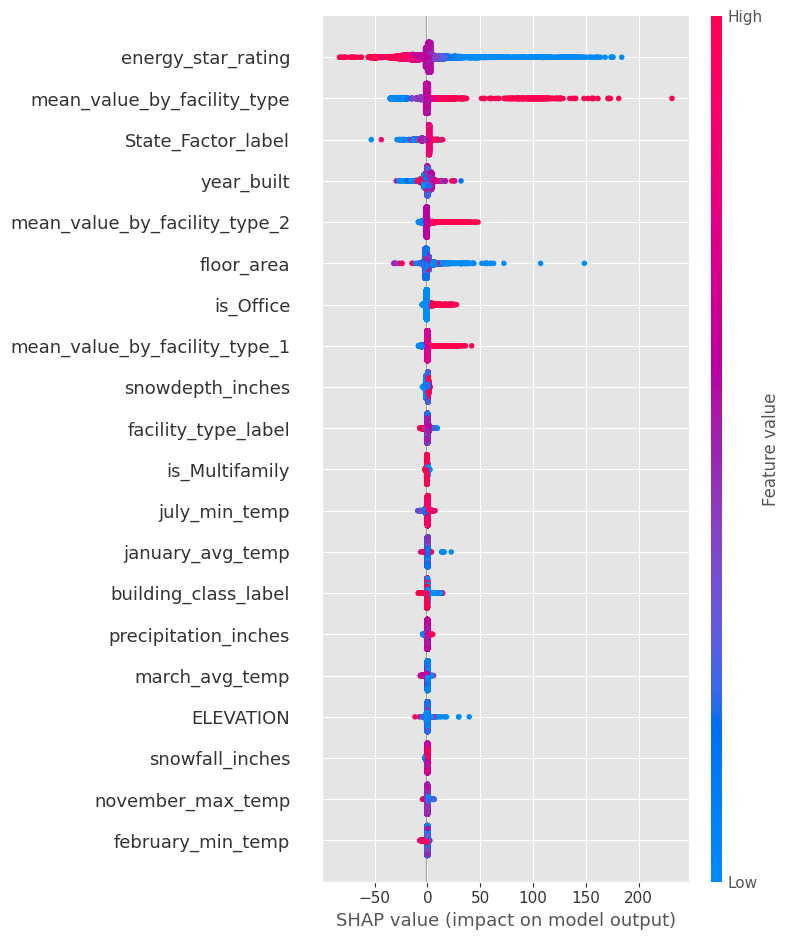

In [161]:
shap.summary_plot(shap_values, X_test_ft)

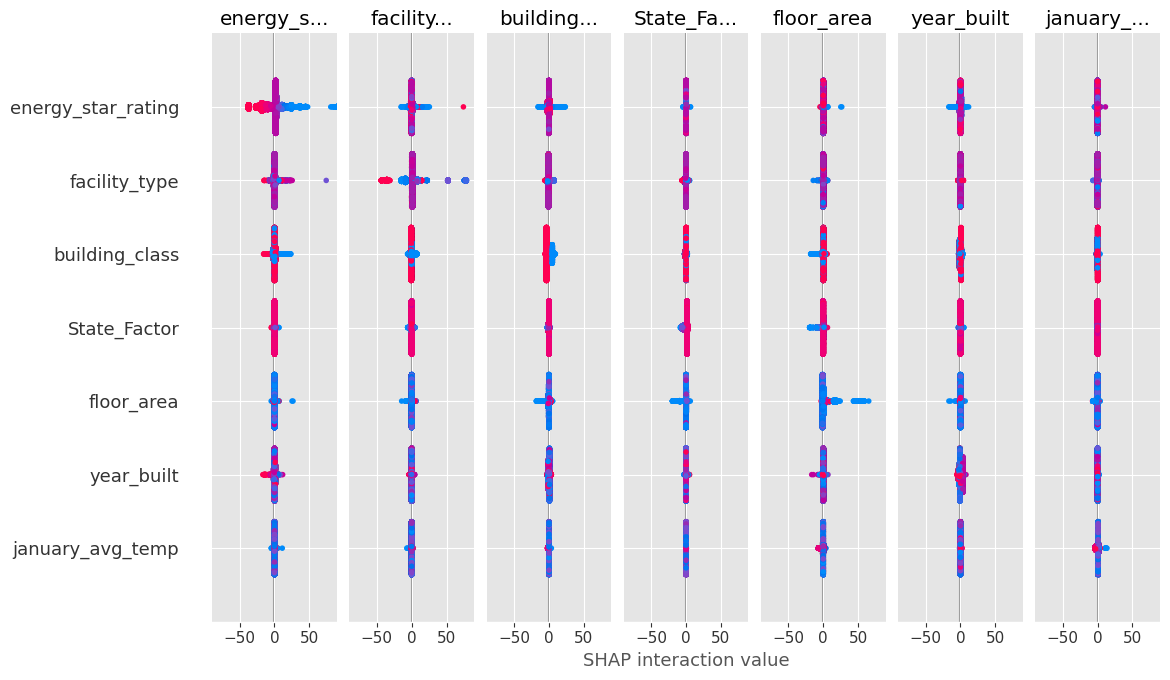

In [40]:
shap_interaction_values = explainer.shap_interaction_values(X_test_ft)
shap.summary_plot(shap_interaction_values, X_test_ft)

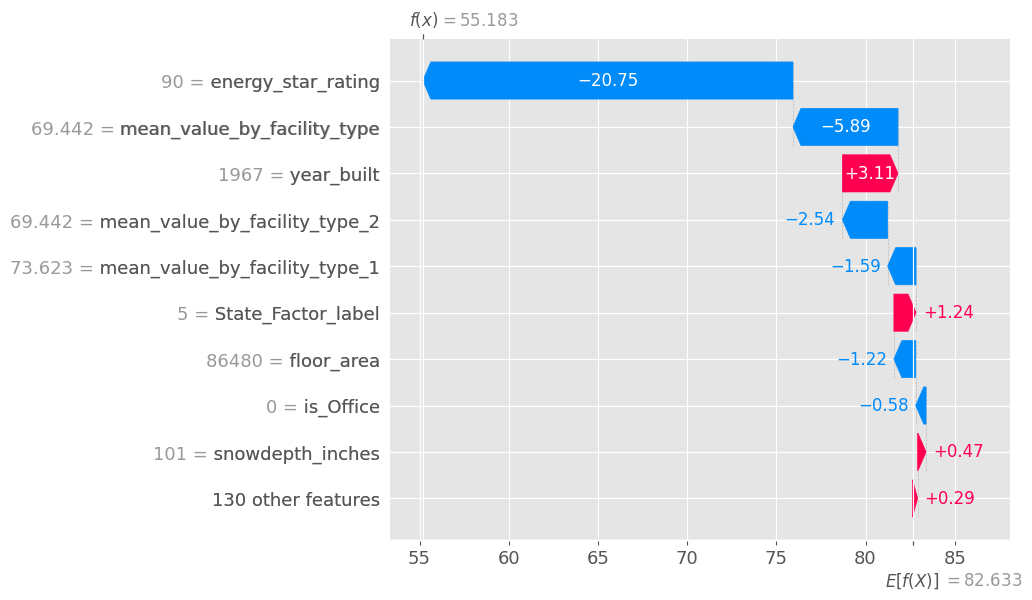

In [162]:
shap.plots.waterfall(shap_values[0])

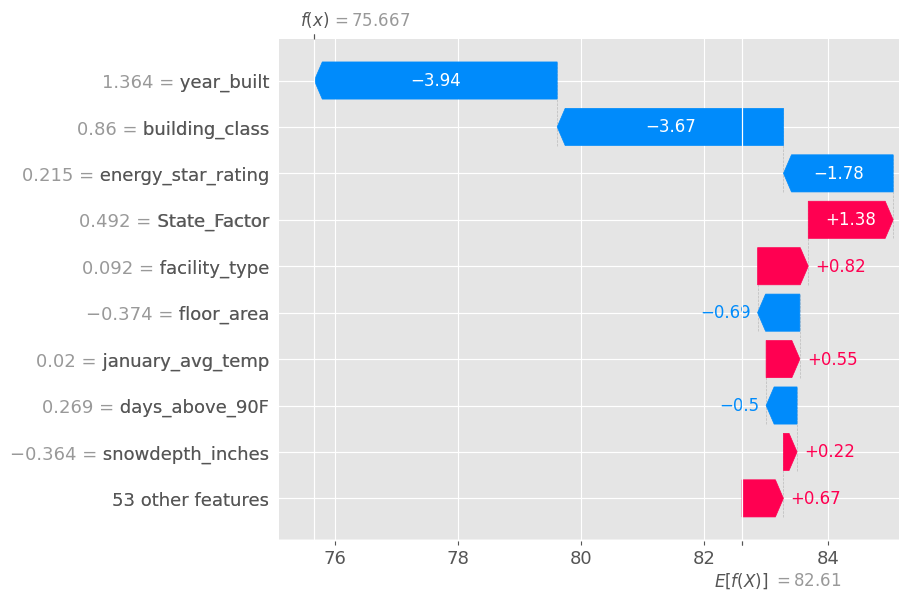

In [ ]:
shap.plots.waterfall(shap_values[1])

In [163]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_ft)
shap.initjs()
def p(j):
    return(shap.force_plot(explainer.expected_value, shap_values[j,:], X_test_ft.iloc[j,:]))
p(0)

NotFittedError: ignored

In [ ]:
p(1)

NameError: ignored

In [ ]:
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test_ft)[0]
shap.decision_plot(expected_value, shap_values, X_test_ft)

In [ ]:
shap_values = explainer.shap_values(X_test_ft)[1]
shap.decision_plot(expected_value, shap_values, X_test_ft)

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                    feature_names=trainnames.columns,
                    class_names=['site_eui'],
                    categorical_features=categorical_features,
                    verbose=True, mode='regression')

In [ ]:
exp = explainer.explain_instance(X_test_ft.iloc[0],
     xgboost_model.predict, num_features=10)
exp.as_pyplot_figure()